In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/btc-usd-hft/bin.btc.usd_2024-09-17.parquet


# Question 1: What is the cost function of Logistic Regression? Explain in Detail.

Logistic regression is used for binary classification problems. The model predicts the probability of the target variable belonging to one of the two classes. The logistic function, also known as the sigmoid function, is used to map the predicted values into a range between 0 and 1. The function is defined as:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$
Where theta epresents the model parameters, and x represents the input features.

The cost function for logistic regression measures the error between the predicted probability and the actual class label. For binary classification, the cost function used is the log-likelihood or log-loss function:
$$
J(\theta) = - \frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log(h_\theta(x^{i)})) + (1 - y^{(i)}) \log(1 - h_\theta(x^{i)})) \right]
$$
Where:
-  m  is the number of training examples,
- y^i is the true class label for the  i-th example,
- theta(x^i) is the predicted probability for the i-th example.

The first term in the cost function is applied when the actual label is 1, and the second term is applied when the actual label is 0. The cost function is minimized during training to improve the model's predictions.

Gradient descent is typically used to minimize the cost function, where the model parameters theta are updated iteratively based on the gradients of the cost function:
$$
\theta := \theta - \alpha \frac{\partial}{\partial \theta} J(\theta)
$$
Where alpha is the learning rate. Minimizing this cost function leads to the best-fitting logistic regression model.

---

# Question 2: What are voting classifiers in ensemble learning?

Voting classifiers are a type of ensemble learning method where multiple models (classifiers) are combined to improve overall prediction performance. In a voting classifier, predictions from different models are aggregated to make a final prediction.

There are two main types of voting classifiers:

1. **Hard Voting**: In hard voting, each classifier makes a class prediction, and the final prediction is made based on the majority vote. The class that receives the most votes from the individual classifiers is selected as the final prediction.
   $$
   \text{Prediction} = \arg \max_y \sum_i 1(y = \hat{y}_i)
   $$
   Where y_i-hat is the prediction of the i-th classifier.

2. **Soft Voting**: In soft voting, each classifier outputs the probability estimates for each class, and the final prediction is made by averaging these probabilities. The class with the highest average probability is chosen as the final prediction.
   $$
   \text{Prediction} = \arg \max_y \sum_i p(y = \hat{y}_i)
   $$

In soft voting, the contribution of each classifier is weighted by the probability it assigns to each class, while in hard voting, only the final class label is considered. Voting classifiers can be applied to combine models like decision trees, support vector machines, and logistic regression to make a more robust classifier. I have used ensemble models, usually in hard voting classifier to cover model weaknesses by combining tree models with neural nets in order to capture non linear relationships witout overfitting.

# Question 3: Follow the 7-steps to model building for your selected ticker

## a) Produce a model to predict positive moves (up trend) using Support Vector Machine (SVM) model

### Importing data

For this Exercise we are importing 24h of high frequency orderbook (20 levels) data (sub 1 millisecond) on BTC-USDT ticker in Binance - given the high frequency of the data I want to investigate if SVM are sophisticated enough to decode potential signals that more complex neural nets have been to decode from order books.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import gc
import os

In [3]:
df= pd.read_parquet('/kaggle/input/btc-usd-hft')
df = df.head(int(len(df) * 1))
gc.collect()

0

## Data exploration and cleaning

In [4]:
df.head(1)

,timestamp,exchange_time,feed_time,eventId_source,eventId_session_number,eventId_sequence,bid_level_count,ask_price_0,ask_size_0,ask_price_1,...,trades_sell_liquidation_count,trades_sell_block_count,funding_rate,open_interest,settlement_price,delivery_price,underlying_price,interest_rate,is_reliable,is_heartbeat
0,1726531200003102498,0,1726531200003072741,1045134377,1724889600,213613961,20,58214.0,4.79395,0.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False,False


In [5]:
print(list(df.columns))

['timestamp', 'exchange_time', 'feed_time', 'eventId_source', 'eventId_session_number', 'eventId_sequence', 'bid_level_count', 'ask_price_0', 'ask_size_0', 'ask_price_1', 'ask_size_1', 'ask_price_2', 'ask_size_2', 'ask_price_3', 'ask_size_3', 'ask_price_4', 'ask_size_4', 'ask_price_5', 'ask_size_5', 'ask_price_6', 'ask_size_6', 'ask_price_7', 'ask_size_7', 'ask_price_8', 'ask_size_8', 'ask_price_9', 'ask_size_9', 'ask_price_10', 'ask_size_10', 'ask_price_11', 'ask_size_11', 'ask_price_12', 'ask_size_12', 'ask_price_13', 'ask_size_13', 'ask_price_14', 'ask_size_14', 'ask_price_15', 'ask_size_15', 'ask_price_16', 'ask_size_16', 'ask_price_17', 'ask_size_17', 'ask_price_18', 'ask_size_18', 'ask_price_19', 'ask_size_19', 'ask_level_count', 'bid_price_0', 'bid_size_0', 'bid_price_1', 'bid_size_1', 'bid_price_2', 'bid_size_2', 'bid_price_3', 'bid_size_3', 'bid_price_4', 'bid_size_4', 'bid_price_5', 'bid_size_5', 'bid_price_6', 'bid_size_6', 'bid_price_7', 'bid_size_7', 'bid_price_8', 'bid_si

## Dropping columns that are uinlikely to carry information

In [6]:
df.drop(['exchange_time', 'feed_time', 'eventId_source', 'eventId_session_number', 'eventId_sequence','is_reliable', 'is_heartbeat' ], axis = 1, inplace = True)

In [7]:
aggregation_rules = {
    'mid': 'last',  
    'bid_level_count': 'first', 
    'ask_level_count': 'first',
    'ask_price_0': 'last', 'ask_size_0': 'sum', 
    'ask_price_1': 'last', 'ask_size_1': 'sum',
    'ask_price_2': 'last', 'ask_size_2': 'sum',
    'ask_price_3': 'last', 'ask_size_3': 'sum',
    'ask_price_4': 'last', 'ask_size_4': 'sum',
    'ask_price_5': 'last', 'ask_size_5': 'sum',
    'ask_price_6': 'last', 'ask_size_6': 'sum',
    'ask_price_7': 'last', 'ask_size_7': 'sum',
    'ask_price_8': 'last', 'ask_size_8': 'sum',
    'ask_price_9': 'last', 'ask_size_9': 'sum',
    'ask_price_10': 'last', 'ask_size_10': 'sum',
    'ask_price_11': 'last', 'ask_size_11': 'sum',
    'ask_price_12': 'last', 'ask_size_12': 'sum',
    'ask_price_13': 'last', 'ask_size_13': 'sum',
    'ask_price_14': 'last', 'ask_size_14': 'sum',
    'ask_price_15': 'last', 'ask_size_15': 'sum',
    'ask_price_16': 'last', 'ask_size_16': 'sum',
    'ask_price_17': 'last', 'ask_size_17': 'sum',
    'ask_price_18': 'last', 'ask_size_18': 'sum',
    'ask_price_19': 'last', 'ask_size_19': 'sum',
    'bid_price_0': 'last', 'bid_size_0': 'sum',
    'bid_price_1': 'last', 'bid_size_1': 'sum',
    'bid_price_2': 'last', 'bid_size_2': 'sum',
    'bid_price_3': 'last', 'bid_size_3': 'sum',
    'bid_price_4': 'last', 'bid_size_4': 'sum',
    'bid_price_5': 'last', 'bid_size_5': 'sum',
    'bid_price_6': 'last', 'bid_size_6': 'sum',
    'bid_price_7': 'last', 'bid_size_7': 'sum',
    'bid_price_8': 'last', 'bid_size_8': 'sum',
    'bid_price_9': 'last', 'bid_size_9': 'sum',
    'bid_price_10': 'last', 'bid_size_10': 'sum',
    'bid_price_11': 'last', 'bid_size_11': 'sum',
    'bid_price_12': 'last', 'bid_size_12': 'sum',
    'bid_price_13': 'last', 'bid_size_13': 'sum',
    'bid_price_14': 'last', 'bid_size_14': 'sum',
    'bid_price_15': 'last', 'bid_size_15': 'sum',
    'bid_price_16': 'last', 'bid_size_16': 'sum',
    'bid_price_17': 'last', 'bid_size_17': 'sum',
    'bid_price_18': 'last', 'bid_size_18': 'sum',
    'bid_price_19': 'last', 'bid_size_19': 'sum',
    'trades_buy_count': 'sum',  # Sum trade counts over the period
    'trades_buy_avg_price': 'last',  # Use the last trade price to reflect end-of-period value
    'trades_buy_volume': 'sum',
    'trades_buy_vwap': 'last',  # Use the last VWAP to reflect end-of-period value
    'trades_buy_liquidation_count': 'sum',
    'trades_buy_block_count': 'sum',
    'trades_sell_count': 'sum',
    'trades_sell_avg_price': 'last',
    'trades_sell_volume': 'sum',
    'trades_sell_vwap': 'last',
    'trades_sell_liquidation_count': 'sum',
    'trades_sell_block_count': 'sum',
    'funding_rate': 'last',
    'open_interest': 'last',
    'settlement_price': 'last',
    'delivery_price': 'last',
    'underlying_price': 'last',
    'interest_rate': 'last',
}


In [8]:
# Create date_time value from timestamp and aggregate
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ns')
df= df.resample('10s', on='timestamp').agg(aggregation_rules)
df=df.reset_index()
df.shape #sanity check for shape 

(8634, 102)

## Creating preprocessing and feature engineering pipeline and creating target variable

In [9]:
# Label log returns
def calculate_target(X):
    X['log_return'] = np.log(X['mid']).diff()
    X.dropna(inplace=True)
    X['log_return_ahead'] = X['log_return'].shift(-1)
    X.dropna(inplace=True)
    # Create lagged returns for 10 periods
    for lag in range(1, 11):
        X[f'lagged__log_return_{lag}'] = X['log_return'].shift(lag)

    # Calculate the moving average of the returns over a window of your choice (e.g., 5 periods)
    moving_average_window = 5  # Adjust the window size as needed
    X['moving_average'] = X['log_return'].rolling(window=moving_average_window).mean()
    
    # Drop any rows with NaN values that may result from shifting or rolling operations
    X = X.dropna().reset_index(drop=True)
    
    y = pd.DataFrame({
        'timestamp': X['timestamp'],  # Keep the timestamp for alignment
        'label': (X['log_return_ahead'] > 0).astype(int)  # Binary target
    })
    return X.drop(columns=['log_return', 'log_return_ahead','timestamp']), y

## Cross Validation function

In [10]:
# For cross validation we will used purged cross validation as it performs just as well or better than rolling or expanding windows for time series

class PurgedKFold:
    def __init__(self, n_splits=5, purge_window=10, embargo_pct=0.01):
        self.n_splits = n_splits
        self.purge_window = purge_window
        self.embargo_pct = embargo_pct
        
    # Add the required get_n_splits method
    def get_n_splits(self, X, y=None, groups=None):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        kf = KFold(n_splits=self.n_splits)
        embargo_size = int(self.embargo_pct * n_samples)

        for train_idx, test_idx in kf.split(X):
            # Define the purge window range
            start_purge = max(0, test_idx[0] - self.purge_window)
            end_purge = min(n_samples, test_idx[-1] + self.purge_window + embargo_size)
            
            # Remove overlapping training indices
            train_idx = train_idx[(train_idx < start_purge) | (train_idx >= end_purge)]
            
            yield train_idx, test_idx



In [11]:
# Define the full pipeline, we assign names to the pipeline so we can then use them to reference specific parameters in the grid search
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scales the features
    ('svc', SVC(kernel='rbf', C=1.0, gamma='scale' , probability = True))  # Support Vector Classifier
])

# Compute the features and target
X, y = calculate_target(df)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## b) Tune hyperparameters for the estimator and present the best model

In [12]:
param_grid = {
    'svc__C': [ 0.5, 1],  # regularization parameter
    'svc__gamma': ['scale', 'auto', 0.001],  #kernel coefficient values
    'svc__kernel': ['linear', 'rbf'],  # Additional kernel types
    'svc__degree': [2, 3],   # for the poly kernel
    'svc__coef0': [0.0, 0.5],  # # fpr poly and sigmoid kernels
    'svc__shrinking': [True],  # shrinking heuristic
    'svc__class_weight': ['balanced', None]  # For handling imbalanced data / we have a slight imbalance so I want to se eif we can do something about it
}



purged_cv = PurgedKFold(n_splits=5, purge_window=15, embargo_pct=0.01)

There are several hyperparameters that SVM/C can take - I will be looking at a subsection of them over the most common values to increase the performance of the SVC without overfitting it to to the data presented

## Create a K-Fold Purged cross validation function - this is suitable for time eries as long as the embargo is large enough

In [13]:
for fold, (train_idx, test_idx) in enumerate(purged_cv.split(X_train, y_train)):
    print(f"Fold {fold}")
    print(f"Length of Train indices: {len(train_idx)}")
    print(f"Length of Test indices: {len(test_idx)}")
    if len(train_idx) > 0 and len(test_idx) > 0:
        print(f"Train start: {X_train.index[train_idx[0]]}, Train end: {X_train.index[train_idx[-1]]}")
        print(f"Test start: {X_train.index[test_idx[0]]}, Test end: {X_train.index[test_idx[-1]]}")
    else:
        print("Empty train or test set!")
    print(f"---")

#Printing out the folds allows me to check if there is anything wrong with the splitting of the data especially when increasing the purging and embargo windows ( there often is :(( )

Fold 0
Length of Train indices: 4754
Length of Test indices: 1207
Train start: 8588, Train end: 7270
Test start: 2542, Test end: 7308
---
Fold 1
Length of Train indices: 4739
Length of Test indices: 1207
Train start: 2542, Train end: 7270
Test start: 8539, Test end: 6474
---
Fold 2
Length of Train indices: 4739
Length of Test indices: 1207
Train start: 2542, Train end: 7270
Test start: 7845, Test end: 6939
---
Fold 3
Length of Train indices: 4739
Length of Test indices: 1207
Train start: 2542, Train end: 7270
Test start: 6012, Test end: 6024
---
Fold 4
Length of Train indices: 4813
Length of Test indices: 1207
Train start: 2542, Train end: 1645
Test start: 3449, Test end: 7270
---


## Tuning the model and reporting the best parameters

In [14]:
print("Starting CV")
grid_search = GridSearchCV(pipeline, param_grid, cv=purged_cv, scoring='accuracy', verbose=2, n_jobs=-1)
y_train = y_train['label']
grid_search.fit(X_train, y_train)


print("Best parameters found: ", grid_search.best_params_)


print("Best score: ", grid_search.best_score_)

Starting CV
Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END svc__C=0.5, svc__class_weight=balanced, svc__coef0=0.0, svc__degree=2, svc__gamma=scale, svc__kernel=linear, svc__shrinking=True; total time=  26.4s
[CV] END svc__C=0.5, svc__class_weight=balanced, svc__coef0=0.0, svc__degree=2, svc__gamma=scale, svc__kernel=linear, svc__shrinking=True; total time=  26.9s
[CV] END svc__C=0.5, svc__class_weight=balanced, svc__coef0=0.0, svc__degree=2, svc__gamma=auto, svc__kernel=linear, svc__shrinking=True; total time=  28.4s
[CV] END svc__C=0.5, svc__class_weight=balanced, svc__coef0=0.0, svc__degree=2, svc__gamma=auto, svc__kernel=rbf, svc__shrinking=True; total time=  20.1s
[CV] END svc__C=0.5, svc__class_weight=balanced, svc__coef0=0.0, svc__degree=2, svc__gamma=auto, svc__kernel=rbf, svc__shrinking=True; total time=  20.8s
[CV] END svc__C=0.5, svc__class_weight=balanced, svc__coef0=0.0, svc__degree=2, svc__gamma=0.001, svc__kernel=linear, svc__shrinking=True; total 

## c) Investigate the prediction quality using area under ROC curve, confusion matrix and classification report.

### Benchmarks

In [15]:
# Logistic regression
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

logistic_probs = logistic_model.predict_proba(X_test)[:, 1] 



# Random Prediction
from sklearn.metrics import classification_report

# Step 1: Calculate the class distribution in the training data
class_0_prob = y_train.value_counts(normalize=True)[0]  # Probability of class 0
class_1_prob = y_train.value_counts(normalize=True)[1]  # Probability of class 1

# Generate random predictions for the test set based on the class probabilities
np.random.seed(42)  # For reproducibility
y_test['random_guessing'] = np.random.choice([0, 1], size=len(y_test), p=[class_0_prob, class_1_prob])




# Naive Benchmark
# Create the naive benchmark predictions by shifting the target column
y_test['naive_prediction'] = y_test['label'].shift(1)

#Fill the first row of the naive prediction with a neutral value
y_test['naive_prediction']=y_test['naive_prediction'].fillna(1)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


I added a selection of random and linear benchmark to contextualize the performance of the model

* **Logistic Regression** = This will provide context versus simpler linear models
* **Random prediciotn** = This is the lowest hurdle to clear and a level 0 for the model, if we fail to beat this convincingly it is a clear sign something is wrong
* **Naive model** = This model takes the reurn as of the previous period as the prediciotn fot eh return of the next - also a small hurdle to clear but a bit higher than random guessing

In [16]:
# Logistic Prediction
y_pred_logistic = logistic_model.predict(X_test)

# SVM Prediction
# Use the best estimator to predict on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the naive benchmark and the SVM model predictions using classification metrics
from sklearn.metrics import classification_report, accuracy_score



# Display Performance

print("Random Guessing Benchmark Classification Report:")
print(classification_report(y_test['label'], y_test['random_guessing']))

print("Naive Benchmark Classification Report:")
print(classification_report(y_test['label'], y_test['naive_prediction']))

print("Logistic Classification Report:")
print(classification_report(y_test['label'], y_pred_logistic))

print("SVM Model Classification Report::")
print(classification_report(y_test['label'], y_pred))




# Additionally, compare the accuracy scores
random_accuracy = accuracy_score(y_test['label'], y_test['random_guessing'])
naive_accuracy = accuracy_score(y_test['label'], y_test['naive_prediction'])
logistic_accuracy = accuracy_score(y_test['label'], y_pred_logistic)
svm_accuracy = accuracy_score(y_test['label'], y_pred)

print(f"Random Guessing Model Accuracy: {random_accuracy}")
print(f"Naive Model Accuracy: {naive_accuracy}")
print(f"Logistic Model Accuracy: {logistic_accuracy}")
print(f"SVMModel Accuracy: {svm_accuracy}")

Random Guessing Benchmark Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.61      0.62      1648
           1       0.36      0.38      0.37       939

    accuracy                           0.53      2587
   macro avg       0.49      0.49      0.49      2587
weighted avg       0.53      0.53      0.53      2587

Naive Benchmark Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.63      0.63      1648
           1       0.36      0.36      0.36       939

    accuracy                           0.53      2587
   macro avg       0.50      0.50      0.50      2587
weighted avg       0.54      0.53      0.54      2587

Logistic Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.93      0.76      1648
           1       0.48      0.12      0.19       939

    accuracy                           0.63      2587
   macro

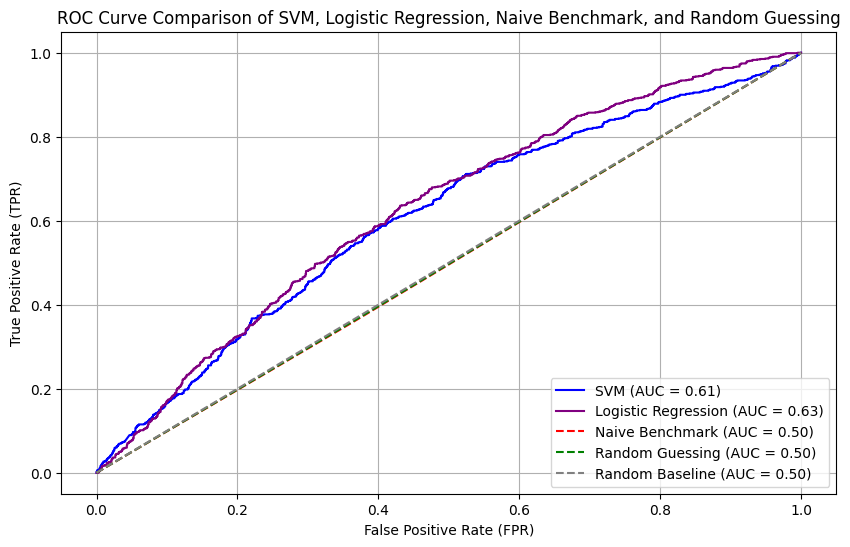

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

#Get the predicted probabilities for the SVM model and Logistic Model
logistic_probs = logistic_model.predict_proba(X_test)[:, 1]  
svm_probs = grid_search.best_estimator_.predict_proba(X_test)[:, 1]  

# Generate random guessing probabilities based on the class distribution in the training data
random_probs = np.random.choice([0, 1], size=len(y_test), p=[class_0_prob, class_1_prob])

# Get the probabilities for the naive benchmark predictions
y_test['naive_prediction'] = y_test['label'].shift(1).fillna(1)  # Shift labels to create naive predictions
naive_probs = y_test['naive_prediction']

# Calculate the ROC curve 
fpr_svm, tpr_svm, _ = roc_curve(y_test['label'], svm_probs)
fpr_logistic, tpr_logistic, _ = roc_curve(y_test['label'], logistic_probs)
fpr_naive, tpr_naive, _ = roc_curve(y_test['label'], naive_probs)
fpr_random, tpr_random, _ = roc_curve(y_test['label'], random_probs)

#AUC scores
auc_svm = auc(fpr_svm, tpr_svm)
auc_logistic = auc(fpr_logistic, tpr_logistic)
auc_naive = auc(fpr_naive, tpr_naive)
auc_random = auc(fpr_random, tpr_random)

#Plot the ROC curve for all models
plt.figure(figsize=(10, 6))
plt.plot(fpr_svm, tpr_svm, color='blue', label=f'SVM (AUC = {auc_svm:.2f})')
plt.plot(fpr_logistic, tpr_logistic, color='purple', label=f'Logistic Regression (AUC = {auc_logistic:.2f})')
plt.plot(fpr_naive, tpr_naive, color='red', linestyle='--', label=f'Naive Benchmark (AUC = {auc_naive:.2f})')
plt.plot(fpr_random, tpr_random, color='green', linestyle='--', label=f'Random Guessing (AUC = {auc_random:.2f})')

# Plot the diagonal line representing the baseline for random guessing
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Baseline (AUC = 0.50)')

# Labels and title for the plot
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Comparison of SVM, Logistic Regression, Naive Benchmark, and Random Guessing')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



## Conclusion

Based on the classification reports and accuracy scores, the Support Vector Machine (SVM) model stands out as the best-performing option in this analysis. While all models show some level of accuracy, the SVM model achieves the highest accuracy at 64.01%, outperforming both the logistic regression model (63.32%) and the benchmarks (52.57% and 53.49%).

In terms of precision, recall, and f1-scores, the SVM shows strong performance in identifying the majority class (0), with a recall of 99% and a balanced f1-score of 0.78, indicating its ability to capture the majority of the positive cases while maintaining reasonable precision. Though the recall for the minority class (1) is low at 3%, the model's overall performance remains superior when the objective is to maximize accuracy and performance for the majority class, as SVM excels in these areas with complex datasets.

Furthermore, SVM’s ability to handle high-dimensional spaces and separate classes with an optimal margin, as well as its ability to use non-linear kernels, makes it highly flexible for challenging classification problems, providing an advantage over simpler models like logistic regression and naive benchmarks.

